In [1]:
! pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 dgl==0.6.0 numpy==1.19.5 networkx==2.5 requests==2.25.1 matplotlib==3.1.3 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
  Attempting uninstall: torch
    Fo

In [2]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [3]:
# Setting torch config
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32

In [4]:
from time import time
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.
        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.
        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)

        return h

# helper function to convert Q dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.
    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat


# Chunk long list
def gen_combinations(combs, chunk_size):
    yield from iter(lambda: list(islice(combs, chunk_size)), [])


# helper function for custom loss according to Q matrix
def loss_func(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.
    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat @ probs_).squeeze()

    return cost


# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.
    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer


# Parent function to run GNN training given input config
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
          print(f'Epoch: {epoch}, Loss: {loss_}')

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return t_gnn, epoch, final_bitstring, best_bitstring

In [5]:
def generate_random_graph(n, k):
    # Create empty graph
    G = nx.Graph()

    # Add n nodes to the graph
    for i in range(n):
        G.add_node(i)

    # Add k edges for each node
    for i in range(n):
        # Make a list of all nodes that aren't i
        other_nodes = list(range(0, i)) + list(range(i+1, n))
        # Randomly select k nodes from the other nodes
        edges = random.sample(other_nodes, k)
        # Add edges to the graph with random weights
        for j in edges:
            G.add_edge(i, j, weight=np.random.random())

    return G

In [6]:
def postprocess_gnn_maxcut(best_bitstring, nx_graph):
    """
    Helper function to postprocess MaxCut results

    Input:
        best_bitstring: bitstring as torch tensor
        nx_graph: NetworkX graph object
    Output:
        maxcut: maximum cut value (float)
        cut_edges: cut edges (list of tuples)
    """
    laplacian = - np.array(nx.laplacian_matrix(nx_graph).todense())
    # Convert bitstring to list of 0s and 1s
    #bitstring_list = best_bitstring.cpu().numpy().tolist()
    partition_gnn_best = best_bitstring.detach().cpu().numpy().astype('float32').reshape((best_bitstring.numel()))
    score_best = -1.0 * partition_gnn_best @ laplacian @ partition_gnn_best.T

    return score_best


In [7]:
dim_embedding = 200 # set gnn input embeding
dropout = 0.0
hidden_dim = int(dim_embedding/2)  # et gnn hidden embeding
# NN learning hypers #
number_epochs = int(1000)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

In [8]:
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': dropout,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

In [9]:
from typing import Tuple, Iterable, Union

import cvxpy as cvx
def goemans_williamson_maxcut(graph: nx.Graph) -> Tuple[np.ndarray, float, float]:

    # Kudos: Originally implementation by Nick Rubin, with refactoring and
    # cleanup by Jonathon Ward and Gavin E. Crooks
    laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())

    # Setup and solve the GW semidefinite programming problem
    psd_mat = cvx.Variable(laplacian.shape, PSD=True)
    obj = cvx.Maximize(cvx.trace(laplacian @ psd_mat))
    constraints = [cvx.diag(psd_mat) == 1]  # unit norm
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.CVXOPT)

    evals, evects = np.linalg.eigh(psd_mat.value)
    sdp_vectors = evects.T[evals > float(1.0E-6)].T

    # Bound from the SDP relaxation
    bound = np.trace(laplacian @ psd_mat.value)

    random_vector = np.random.randn(sdp_vectors.shape[1])
    random_vector /= np.linalg.norm(random_vector)
    colors = np.sign([vec @ random_vector for vec in sdp_vectors])
    score = colors @ laplacian @ colors.T

    return score

In [10]:
def maxcut(g, n, k):
    maxcut = goemans_williamson_maxcut(g)
    return maxcut

In [11]:
import matplotlib.pyplot as plt
real_solutions = []
found_solutions = []
n=40
K = [i for i in range(1,n) if i*n%2==0] # set range of graph degree

for k in K:
    nx_graph = generate_random_graph(n, k)
    graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    laplacian = - np.array(nx.laplacian_matrix(nx_graph).todense())
    q_torch = torch.tensor(laplacian, dtype=TORCH_DTYPE, device=TORCH_DEVICE)
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    dt_gnn, epoch, final_bitstring, best_bitstring = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])
    cut_value_gnn = postprocess_gnn_maxcut(best_bitstring, nx_graph)

    found_solutions.append(cut_value_gnn)
    real_solution = maxcut(nx_graph, n, k)
    real_solutions.append(real_solution)


Epoch: 0, Loss: -0.6485720276832581
Epoch: 0, Loss: -0.4397483468055725
Epoch: 0, Loss: -0.41742897033691406
Epoch: 0, Loss: -0.0793580710887909
Epoch: 0, Loss: -0.05229845643043518
Epoch: 0, Loss: -0.11673089116811752
Epoch: 0, Loss: -0.056161630898714066
Epoch: 0, Loss: -0.07845895737409592
Epoch: 0, Loss: -0.04046173021197319
Epoch: 0, Loss: -0.043837979435920715
Epoch: 0, Loss: -0.060273222625255585
Epoch: 0, Loss: -0.039118699729442596
Epoch: 0, Loss: -0.025571390986442566
Epoch: 0, Loss: -0.01332783605903387
Epoch: 0, Loss: -0.01172733772546053
Epoch: 0, Loss: -0.00551591906696558
Epoch: 0, Loss: -0.04465116187930107
Epoch: 0, Loss: -0.036797553300857544
Epoch: 0, Loss: -0.011846772395074368
Epoch: 0, Loss: -0.004578003194183111
Epoch: 0, Loss: -0.005897808354347944
Epoch: 0, Loss: -0.0042790877632796764
Epoch: 0, Loss: -0.004316993057727814
Epoch: 0, Loss: -0.0037059630267322063
Epoch: 0, Loss: -0.012537031434476376
Epoch: 0, Loss: -0.0008668761583976448
Epoch: 0, Loss: -0.00220

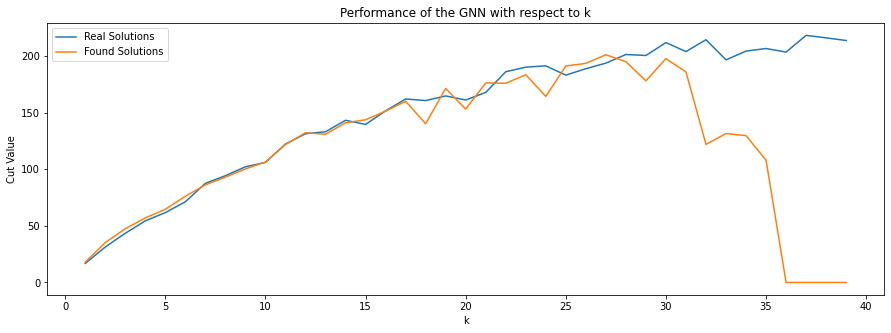

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(K, real_solutions, label='Real Solutions')
plt.plot(K, found_solutions, label='Found Solutions')
plt.title("Performance of the GNN with respect to k")
plt.xlabel('k')
plt.ylabel('Cut Value')
plt.legend()
plt.show()

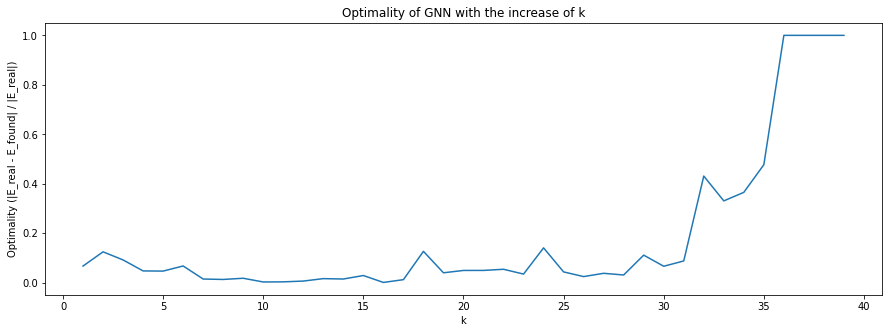

In [18]:
optimality_gnn = [abs(real_solutions[i] - found_solutions[i]) / real_solutions[i] for i in range(len(K))]

plt.figure(figsize=(15, 5))
plt.plot(K, optimality_gnn)
plt.title("Optimality of GNN with the increase of k")
plt.xlabel('k')
plt.ylabel('Optimality (|E_real - E_found| / |E_real|)')
plt.show()

There are several classic algorithms that can solve the max-cut problem. Here are a few examples:

Kernighan-Lin Algorithm: This algorithm iteratively improves a given initial partition of the vertices in the graph. It has no performance guarantee, but it often performs well in practice.

Simulated Annealing: This is a stochastic search algorithm that randomly perturbs the current solution and accepts it with a certain probability. It has no performance guarantee, but it often performs well in practice.

Tabu Search: This is another stochastic search algorithm that maintains a list of forbidden moves (tabu list) to avoid getting stuck in local optima. It has no performance guarantee, but it often performs well in practice.

Use a different GNN architecture: There are many different GNN architectures, each with their own strengths and weaknesses. You can try using a different GNN architecture, such as a Graph Attention Network (GAT) or a Graph Isomorphism Network (GIN), to see if it performs better on your specific problem.

If the structure of the graph is known, you can use some techniques to improve the performance of the presented GNN:

Increase the number of layers: Since you know the structure of the graph, you can design a deeper GNN architecture that is tailored to exploit the specific properties of the graph. A deeper architecture may be able to capture more complex relationships between nodes.

Adjust the weight initialization: You can try different weight initialization techniques to ensure that the model is initialized with weights that will converge to a good solution. One way to do this is to use Xavier initialization or He initialization, which are common techniques for initializing neural network weights.

Use a different activation function: The presented GNN uses the ReLU activation function in the hidden layers and the sigmoid activation function in the output layer. You can try using a different activation function, such as the hyperbolic tangent (tanh) or the rectified linear unit (ReLU), to see if it improves the performance of the model.

Use different aggregation functions: The aggregation function used in the presented GNN is a simple mean aggregation. However, depending on the properties of the graph, different aggregation functions may perform better. For example, for a graph with a hierarchical structure, a hierarchical aggregation function may perform better.


Use attention mechanisms: Attention mechanisms allow the GNN to focus on important nodes or edges in the graph, which can be particularly useful if the graph is large and complex. By attending to important nodes or edges, the GNN can better capture the underlying relationships between nodes.